# Project 1

## Project Overview

In this project we aim to study if and how the climate has changed over the past decade or so. The focus of my analysis is specifically on changes in precipitation as captured by weather stations across the US.

Areas in the US with the highest annual rainfall tend to be along the coasts and in the southeast region, according to this [map](https://www.tripsavvy.com/wettest-places-in-the-usa-4135027). With increasing severity of the effects of climate change there are reports that the frequency, quantity and spread of rainfall are all increasing across the US ([USA Today](https://www.usatoday.com/story/news/weather/2019/08/04/climate-change-extreme-weather-getting-worse-in-these-20-places/39873609/)). Although it is hypothesized that the Earth will become subject to a phenomenon known as *weather wiplash*, in which periods of extreme rain are followed by periods of extreme drought, it is predicted that when it does rain, this rainfall will be more severe ([Vox](https://www.vox.com/a/weather-climate-change-us-cities-global-warming)).

In this anlaysis, I have set out to determine if and how precipitation does appear to have increased from the early 1900s to the 2000s. At the very least this analysis aims to determine if there have been any significant changes or apparent trends in rainfall over the past decade.

The data are taken from the [NOAA USHCN](https://www.ncdc.noaa.gov/ushcn/introduction) data archive.

All analyses were carried out in the following notebook and are split into the following sections:
### 1. [Setup](#setup)
   - [Creation of dictionaries and functions that will be used for data visualization](#creation)
   - [Data consolidation](#data-consolidation)
   
### 2. [Comparison of precipitation at two time points (Task 1)](#task-1)
   - [Map plot of January 1910 and January 2010 precipitation values](#map-plot-1)
   - [Histogram showing the spread of precipitation differences between these two time points across all weather stations](#histogram-1)
   - [Histogram showing the spread of precipitation differences between the 1910 and 2010 average precipitation across all weather stations](#histogram-2)
   - [Map plot of 1910 and 2010 average precipitation values](#map-plot-1.1)
   
### 3. [Precipitation analysis via Permutation (Task 2)](#task-2)
   - [Permutation test for average summer precipitation change between the 30yr time periods 1905-1935 and 1985-2015](#perm-test)
   - [Map plot of permutation test p-values](#map-plot-2)
   - [Investigation into nature of precipitation difference between the time periods](#diff-investigation)
   
### 4. [ Comparison of Average Rainfall Trends between US Regions](#regions)

<a id="setup"></a>
## 1. Setup

#### Import required libraries and modules

In [1]:
import pandas as pd
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

<a id="creation"></a>
***
#### Create color palettes for visualizations

In [129]:
color_palette = {0:"#f8f8ff", 1:"#ffe4e1", 2:"#ffa07a", 3:"#e9967a", 4:"#fa8072", 5:"#cd5c5c", 6:"#b22222", 7:"#8b0000"}

In [3]:
color_palette2 = {1:"#add8e6", 2:"#6495ed", 3:"#4169e1", 4:"#0000cd", 5:"#191970", -1:"#ffe4e1", -2:"#ffa07a", -3:"#e9967a", -4:"#fa8072", -5:"#8b0000"}

#### Define functions that will classify points on the map

In [4]:
def classify_prcp(intervals, val):
    '''
    This function requires:
        - a list of interval values
        - a value to classify
        
    It assumes there are 7 intervals.
    
    It returns an integer corresponding to the interval
    in which the input value is found (these numbers
    correspond to the color categories).     
    '''
    
    if np.isnan(val):
        return 0
    elif val >= intervals[6] and val < intervals[7]:
        return 7
    elif val >= intervals[5] and val < intervals[6]:
        return 6
    elif val >= intervals[4] and val < intervals[5]:
        return 5
    elif val >= intervals[3] and val < intervals[4]:
        return 4
    elif val >= intervals[2] and val < intervals[3]:
        return 3
    elif val >= intervals[1] and val < intervals[2]:
        return 2
    elif val >= intervals[0] and val < intervals[1]:
        return 1
    else:
        return 0

In [5]:
def classify_p(p_val):
    '''
    This function requires:
        - a p-value to classify
        
    It returns an integer corresponding to the interval
    in which this p-value is found (these numbers correspond
    to the color categories).
    '''
    
    if p_val <= 0.05:
        return 7
    elif p_val <= 0.1:
        return 5
    elif p_val <= 0.2:
        return 3
    elif p_val <= 1:
        return 1

In [6]:
def classify_frac(frac, upper_lower):
    '''
    This function requires:
        - a fraction to classify
        - a string indicating if we're doing an upper or lower test
    
    It returns an integer corresponding to the interval
    in which this fraction is found (these numbers correspond
    to color categories).
    '''
    
    if upper_lower == "upper":
        if frac >= 0.9:
            return 5
        elif frac >= 0.8:
            return 4
        elif frac >= 0.7:
            return 3
        elif frac >= 0.6:
            return 2
        else:
            return 1
    else:
        if frac >= 0.9:
            return -5
        elif frac >= 0.8:
            return -4
        elif frac >= 0.7:
            return -3
        elif frac >= 0.6:
            return -2
        else:
            return -1

<a id="data-consolidation"></a>
***
#### Data consolidation

In [7]:
### Load the datafile with longitude and latitude information for weather stations ###

station_meta = pd.read_csv("csvs/station_metadata.csv")

# set index=id for easy access
station_meta = station_meta.set_index("id")

print(station_meta.shape)
station_meta.head(3)

(1218, 13)


,component_1,component_2,component_3,coop_id,country_code,elevation,id_place_holder,latitude,longitude,name,network_code,state,utc_offset
id,,,,,,,,,,,,,
USH00011084,------,------,------,11084,US,25.9,0,31.0581,-87.0547,BREWTON 3 SSE,H,AL,6
USH00012813,------,------,------,12813,US,7.0,0,30.5467,-87.8808,FAIRHOPE 2 NE,H,AL,6
USH00013160,011694,------,------,13160,US,38.1,0,32.8347,-88.1342,GAINESVILLE LOCK,H,AL,6


In [8]:
### Collect all files with precipitation information ###

prcp_files = []
for file_name in os.listdir("csvs/"):
    if "prcp" in file_name:
        prcp_files.append(file_name)
        
print(len(prcp_files))

1218


<a id="task-1"></a>
## 2. Comparison of precipitation at two time points (Task 1)

<a id="map-plot-1"></a>
### Map plot of January 1910 and January 2010 precipitation values

In [7]:
### Create master dataframe to hold precipitation values for Jan 1910 and Jan 2010 ###
# january record = value0

prcp_master = pd.DataFrame(columns=["id", "Jan1910", "Jan2010"])
df_i = 0

for prcp_file in prcp_files:
    
    station_id = prcp_file.split(".")[0]
    
    prcp_df = pd.read_csv("csvs/"+prcp_file)
    
    # set index=year for easy access
    prcp_df = prcp_df.set_index("year")
    
    # get jan 1910 record
    try:
        prcp_1910_val = prcp_df.loc[1910, "value0"]
        if prcp_1910_val < 0:
            #missing
            jan_1910_prcp = np.nan
        else:
            jan_1910_prcp = prcp_1910_val/10.0 #convert to mm
    except KeyError:
        #missing
        jan_1910_prcp = np.nan
        
    # get jan 2010 record
    try:
        prcp_2010_val = prcp_df.loc[2010, "value0"]
        if prcp_2010_val < 0:
            #missing value
            jan_2010_prcp = np.nan
        else:
            jan_2010_prcp = prcp_2010_val/10.0 #convert to mm
    except KeyError:
        #missing
        jan_2010_prcp = np.nan
    
    # add to master dataframe
    prcp_master.loc[df_i, :] = [station_id, jan_1910_prcp, jan_2010_prcp]
    df_i += 1
    
prcp_master = prcp_master.set_index("id")

In [113]:
### Save/load prcp_master.csv ###
#prcp_master.to_csv("prcp_master.csv")
prcp_master = pd.read_csv("prcp_master.csv", index_col="id")
prcp_master.head()

,Jan1910,Jan2010
id,,
USH00031596,65.9,63.8
USH00244522,5.2,10.7
USH00410639,76.5,74.3
USH00103732,48.0,24.1
USH00051564,0.0,1.3


In [114]:
jan_1910_range = (np.min(prcp_master.Jan1910), np.max(prcp_master.Jan1910))
jan_2010_range = (np.min(prcp_master.Jan2010), np.max(prcp_master.Jan2010))
print("Jan 1910 range:", jan_1910_range)
print("Jan 2010 range:", jan_2010_range)

Jan 1910 range: (0.0, 514.1)
Jan 2010 range: (0.0, 687.0)


In [117]:
### Create 7 intervals for precipitation values ###
# these intervals will be over the range (0, 687]

min_prcp = jan_2010_range[0]
max_prcp = jan_2010_range[1] + 0.1 #add 0.1 to handle boundary issues
int_width = max_prcp/7.0

intervals = []
int_bound = min_prcp
intervals.append(int_bound)
for i in range(6):
    int_bound = math.floor(int_bound + int_width)
    intervals.append(int_bound)

intervals.append(max_prcp)
intervals

[0.0, 98, 196, 294, 392, 490, 588, 687.1]

In [131]:
### Classify precipitation values according to the interval in which they fall ###
# the integer used to classify each will correspond to a color in the color palette

# get and classify 1910 points for plot
stations_1910 = [s_id for s_id in prcp_master.index if prcp_master.loc[s_id, "Jan1910"] != None]
x_vals_1910 = [station_meta.loc[s_id, "longitude"] for s_id in stations_1910]
y_vals_1910 = [station_meta.loc[s_id, "latitude"] for s_id in stations_1910]
classify_1910 = [classify_prcp(intervals, prcp_master.loc[s_id, "Jan1910"]) for s_id in stations_1910]
colors_1910 = [color_palette[s_class] for s_class in classify_1910]

# get and classify 2010 points for plot
stations_2010 = [s_id for s_id in prcp_master.index if prcp_master.loc[s_id, "Jan2010"] != None]
x_vals_2010 = [station_meta.loc[s_id, "longitude"] for s_id in stations_2010]
y_vals_2010 = [station_meta.loc[s_id, "latitude"] for s_id in stations_2010]
classify_2010 = [classify_prcp(intervals, prcp_master.loc[s_id, "Jan2010"]) for s_id in stations_2010]
colors_2010 = [color_palette[s_class] for s_class in classify_2010]

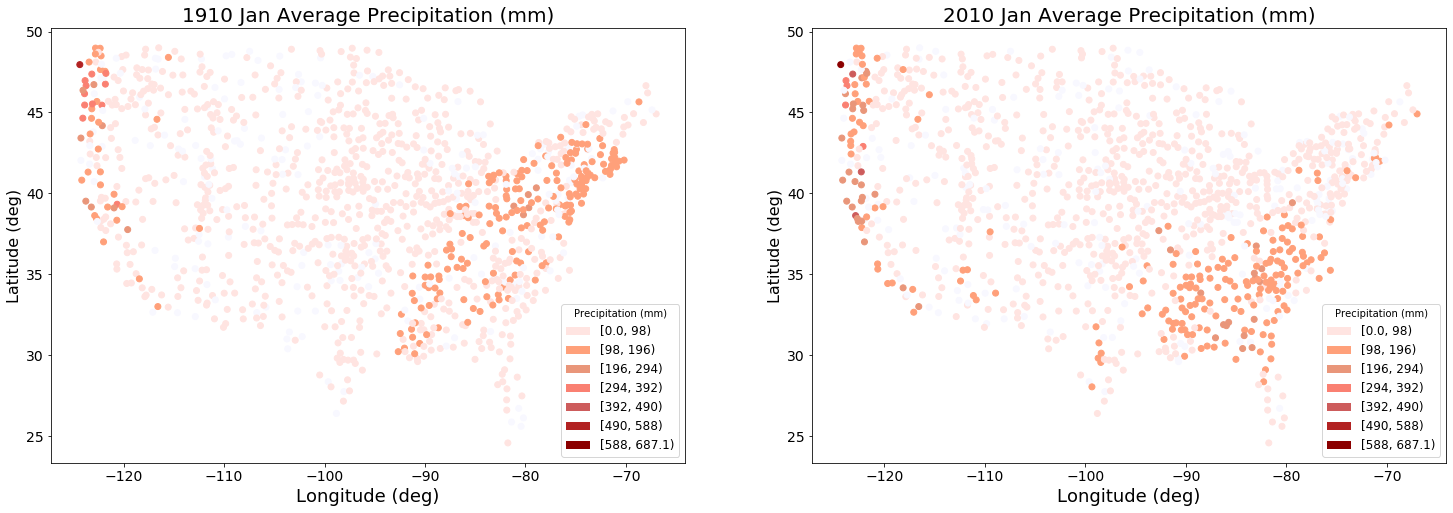

In [133]:
### Create map plot ###

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))

# create legend
legend_labels = ["[0.0, 98)", "[98, 196)", "[196, 294)", "[294, 392)", "[392, 490)", "[490, 588)", "[588, 687.1)"]
legend_boxes = []
for col_i in range(1, 8):
    box = Rectangle((0, 0), 1, 1, fc=color_palette[col_i])
    legend_boxes.append(box)

ax1.scatter(x_vals_1910, y_vals_1910, color=colors_1910)
ax1.set_title('1910 Jan Average Precipitation (mm)', fontsize=20)
ax1.set_xlabel('Longitude (deg)', fontsize=18)
ax1.set_ylabel('Latitude (deg)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(legend_boxes, legend_labels, title="Precipitation (mm)", loc="lower right", fontsize=12)

ax2.scatter(x_vals_2010, y_vals_2010, color=colors_2010)
ax2.set_title('2010 Jan Average Precipitation (mm)', fontsize=20)
ax2.set_xlabel('Longitude (deg)', fontsize=18)
ax2.set_ylabel('Latitude (deg)', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.legend(legend_boxes, legend_labels, title="Precipitation (mm)", loc="lower right", fontsize=12)

plt.savefig("map-plot-jan-avg-prcp.jpeg")
#plt.savefig("missing-map-plot-jan-avg-prcp.jpeg")

plt.show()

### Discussion

As expected, regions along the coast experienced more rainfall in both January 1910 and January 2010 than did inland areas.

We do not, however, see any major increase in volume of precipitation from 1910 to 2010 if only January precipitation values are considered.

Lastly, the eastern patch of heavier rainfall in 1910 appears to have moved more to the south in 2010, which is consistent with the usual changes in weather systems.

<a id="histogram-1"></a>
### Histogram showing the spread of precipitation differences between these two time points across all weather stations

Here we analyze the change in *January* precipitation from 1910 to 2010 through a histogram which shows the spread of precipitation differences between these two time points across all weather stations.

In [21]:
prcp_master = pd.read_csv("prcp_master.csv", index_col="id")

In [22]:
### Calculate the difference in precipitation from Jan 1910 to Jan 2010 ###

prcp_diff_single = pd.DataFrame(columns=["id", "prcp_diff"])
prcp_diff_single = prcp_diff_single.set_index("id")

for station in prcp_master.index:
    jan19 = prcp_master.loc[station, "Jan1910"]
    jan20 = prcp_master.loc[station, "Jan2010"]
    if not np.isnan(jan19) and not np.isnan(jan20):
        diff = jan20 - jan19
        prcp_diff_single.loc[station, :] = diff
    
prcp_diff_single.to_csv("prcp_diff_Jan1910-2010.csv")

In [123]:
prcp_diff_single = pd.read_csv("prcp_diff_Jan1910-2010.csv", index_col="id")
print(prcp_diff_single.shape)
prcp_diff_single.head()

(874, 1)


,prcp_diff
id,
USH00031596,-2.1
USH00244522,5.5
USH00410639,-2.2
USH00103732,-23.9
USH00051564,1.3


In [124]:
print("min change:", np.min(prcp_diff_single.prcp_diff))
print("max change:", np.max(prcp_diff_single.prcp_diff))

min change: -141.7
max change: 260.5


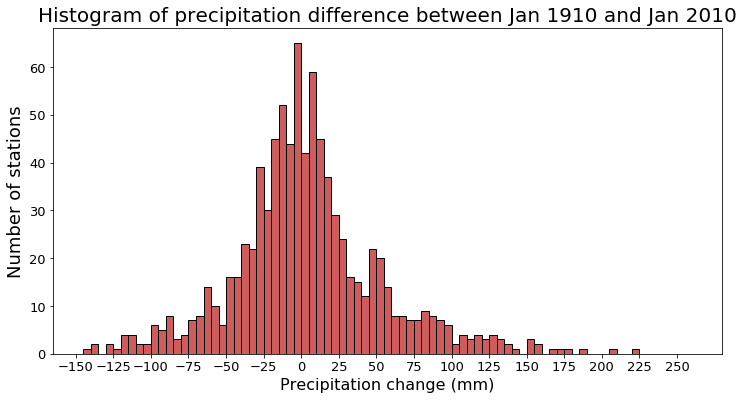

In [125]:
### Create histogram ###

fig, ax = plt.subplots(figsize=(12,6))

ax.hist(prcp_diff_single.prcp_diff.astype(float), bins=np.arange(-145, 265, 5), color=color_palette[5], edgecolor="black")
ax.set_title('Histogram of precipitation difference between Jan 1910 and Jan 2010', fontsize=20)
ax.set_ylabel('Number of stations', fontsize=18)
ax.set_xlabel('Precipitation change (mm)', fontsize=16)
ax.set_xticks(np.arange(-150, 275, 25))
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("histogram-prcp-diff-jan1910-jan2010.jpeg")

plt.show()

### Discussion

The above distribution is approximately normally distributed and centered around 0mm. This indicates that the majority of weather stations reported no significant difference between January 1910 and January 2010 rainfall.

There is however, a slight right-skew to the distribution, which may indicate that a greater proportion of weather stations saw a decrease in precipitation from January 1910 to January 2010.

<a id="histogram-2"></a>
### Histogram showing the spread of precipitation differences between the 1910 and 2010 average precipitation across all weather stations

January 1910 and January 2010 are two *very* specific time points. It might also be interesting to analyze the difference in average rainfall over all months from 1910 to 2010 instead, to get a clearer picture of any changes in precipitation trends between the ends of a decade.

Here we analyze the change in *average* precipitation from 1910 to 2010 through a histogram which shows the spread of precipitation differences between the 1910 and 2010 average precipitation across all weather stations.

In [28]:
### Create master dataframe to hold precipitation average values for 1910 and 2010 ###

prcp_avg_master = pd.DataFrame(columns=["id", "1910_avg", "2010_avg"])
df_i = 0

month_vals = ["value"+str(i) for i in range(12)]

for prcp_file in prcp_files:
    
    station_id = prcp_file.split(".")[0]
    
    prcp_df = pd.read_csv("csvs/"+prcp_file)
    
    # set index=year for easy access
    prcp_df = prcp_df.set_index("year")
    
    prcp_1910, prcp_2010 = [], []
    
    for month in month_vals:
        # get 1910 values
        try:
            prcp_1910_val = prcp_df.loc[1910, month]
            if prcp_1910_val < 0:
                #missing
                prcp_1910.append(np.nan)
            else:
                prcp_1910.append(prcp_1910_val/10.0) #convert to mm
        except KeyError:
            #missing
            prcp_1910.append(np.nan)
        
        # get 2010 values
        try:
            prcp_2010_val = prcp_df.loc[2010, month]
            if prcp_2010_val < 0:
                #missing value
                prcp_2010.append(np.nan)
            else:
                prcp_2010.append(prcp_2010_val/10.0) #convert to mm
        except KeyError:
            #missing
            prcp_2010.append(np.nan)
            
    mean_1910 = np.mean(prcp_1910)
    mean_2010 = np.mean(prcp_2010)
    
    # add to master dataframe
    prcp_avg_master.loc[df_i, :] = [station_id, mean_1910, mean_2010]
    df_i += 1

prcp_avg_master = prcp_avg_master.set_index("id")

In [135]:
#prcp_avg_master.to_csv("prcp_avg_master.csv")
prcp_avg_master = pd.read_csv("prcp_avg_master.csv", index_col="id")
prcp_avg_master.head()

,1910_avg,2010_avg
id,,
USH00031596,106.858333,84.516667
USH00244522,10.241667,36.783333
USH00410639,63.083333,86.041667
USH00103732,20.950000,32.516667
USH00051564,NaN,28.783333


In [33]:
### Calculate the difference in yearly average precipitation from 1910 to 2010 ###

prcp_diff_avg = pd.DataFrame(columns=["id", "prcp_diff"])
prcp_diff_avg = prcp_diff_avg.set_index("id")

for station in prcp_avg_master.index:
    avg_19 = prcp_avg_master.loc[station, "1910_avg"]
    avg_20 = prcp_avg_master.loc[station, "2010_avg"]
    if not np.isnan(avg_19) and not np.isnan(avg_20):
        diff = avg_20 - avg_19
        prcp_diff_avg.loc[station, :] = diff

In [136]:
#prcp_diff_avg.to_csv("prcp_diff_1910-2010.csv")
prcp_diff_avg = pd.read_csv("prcp_diff_1910-2010.csv", index_col="id")
print(prcp_diff_avg.shape)
prcp_diff_avg.head()

(706, 1)


,prcp_diff
id,
USH00031596,-22.341667
USH00244522,26.541667
USH00410639,22.958333
USH00103732,11.566667
USH00153762,-52.100000


In [137]:
print("min change:", np.min(prcp_diff_avg.prcp_diff))
print("max change:", np.max(prcp_diff_avg.prcp_diff))

min change: -55.79166666666667
max change: 85.40833333333333


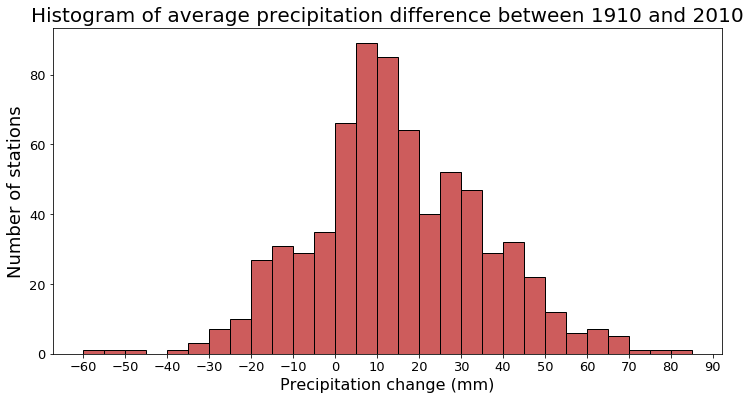

In [128]:
### Create histogram ###

fig, ax = plt.subplots(figsize=(12,6))

ax.hist(prcp_diff_avg.prcp_diff.astype(float), bins=np.arange(-60, 90, 5), color=color_palette[5], edgecolor="black")
ax.set_title('Histogram of average precipitation difference between 1910 and 2010', fontsize=20)
ax.set_ylabel('Number of stations', fontsize=18)
ax.set_xlabel('Precipitation change (mm)', fontsize=16)
ax.set_xticks(np.arange(-60, 100, 10))
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("histogram-prcp-diff-1910-2010.jpeg")

plt.show()

### Discussion

This distribution is also a quite normally distributed and is less right skewed than the previous distribution. This distribution, however, is centered around 10mm (not 0mm). This indicates that on average, most weather stations saw an increase in average precipitation from 1910 to 2010.

<a id="map-plot-1.1"></a>
### Map plot of 1910 and 2010 average precipitation values

Similarly to the first map plot, we can plot the average precipitation values reported by each weather station for 1910 and 2010

In [138]:
### Obtain the range of average precipitation values across stations for 1910 and 2010 ###

range_1910 = (np.min(prcp_avg_master["1910_avg"]), np.max(prcp_avg_master["1910_avg"]))
range_2010 = (np.min(prcp_avg_master["2010_avg"]), np.max(prcp_avg_master["2010_avg"]))
print("1910 range:", range_1910)
print("2010 range:", range_2010)

1910 range: (0.44166666666666665, 253.4)
2010 range: (6.3916666666666675, 293.5833333333333)


In [139]:
### Create 7 intervals for precipitation values ###
# these intervals will be over the range (0, 694]

min_prcp = 0
max_prcp = range_2010[1]
int_width = max_prcp/7.0

intervals = []
int_bound = min_prcp
intervals.append(int_bound)
for i in range(6):
    int_bound = math.floor(int_bound + int_width)
    intervals.append(int_bound)

intervals.append(max_prcp)
intervals

[0, 41, 82, 123, 164, 205, 246, 293.5833333333333]

In [140]:
### Classify precipitation values according to the interval in which they fall ###
# the integer used to classify each will correspond to a color in the color palette

# get and classify 1910 points for plot
stations_1910 = [s_id for s_id in prcp_avg_master.index if prcp_avg_master.loc[s_id, "1910_avg"] != None]
x_vals_1910 = [station_meta.loc[s_id, "longitude"] for s_id in stations_1910]
y_vals_1910 = [station_meta.loc[s_id, "latitude"] for s_id in stations_1910]
classify_1910 = [classify_prcp(intervals, prcp_avg_master.loc[s_id, "1910_avg"]) for s_id in stations_1910]
colors_1910 = [color_palette[s_class] for s_class in classify_1910]

# get and classify 2010 points for plot
stations_2010 = [s_id for s_id in prcp_avg_master.index if prcp_avg_master.loc[s_id, "2010_avg"] != None]
x_vals_2010 = [station_meta.loc[s_id, "longitude"] for s_id in stations_2010]
y_vals_2010 = [station_meta.loc[s_id, "latitude"] for s_id in stations_2010]
classify_2010 = [classify_prcp(intervals, prcp_avg_master.loc[s_id, "2010_avg"]) for s_id in stations_2010]
colors_2010 = [color_palette[s_class] for s_class in classify_2010]

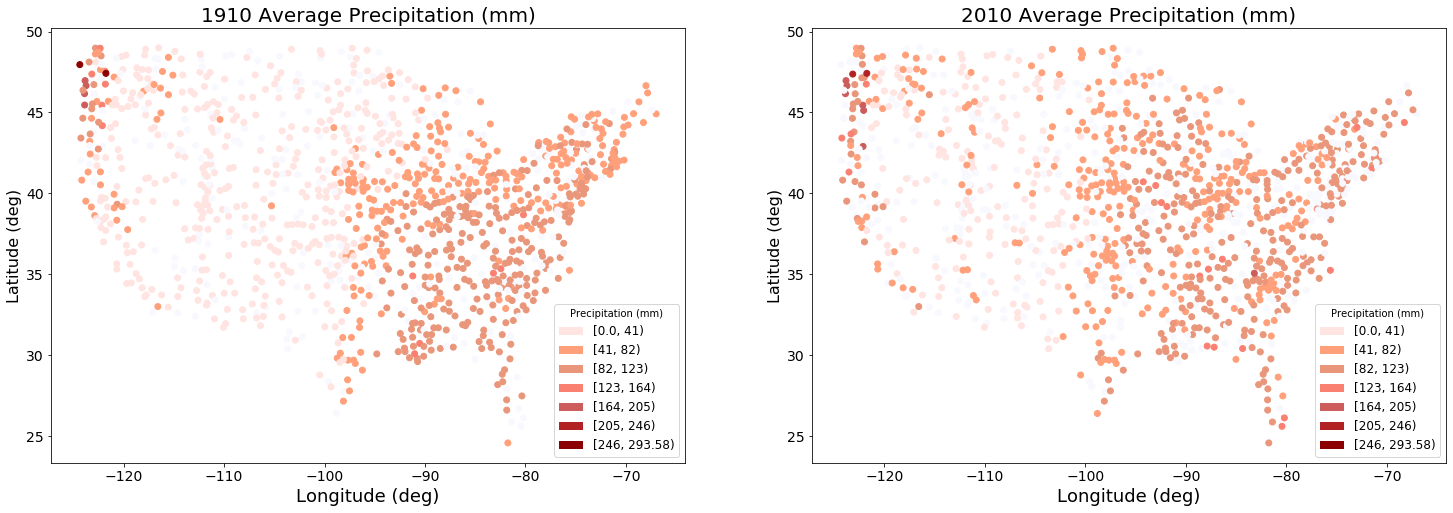

In [142]:
### Create map plot ###

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))

# create legend
legend_labels = ["[0.0, 41)", "[41, 82)", "[82, 123)", "[123, 164)", "[164, 205)", "[205, 246)", "[246, 293.58)"]
legend_boxes = []
for col_i in range(1, 8):
    box = Rectangle((0, 0), 1, 1, fc=color_palette[col_i])
    legend_boxes.append(box)

ax1.scatter(x_vals_1910, y_vals_1910, color=colors_1910)
ax1.set_title('1910 Average Precipitation (mm)', fontsize=20)
ax1.set_xlabel('Longitude (deg)', fontsize=18)
ax1.set_ylabel('Latitude (deg)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(legend_boxes, legend_labels, title="Precipitation (mm)", loc="lower right", fontsize=12)

ax2.scatter(x_vals_2010, y_vals_2010, color=colors_2010)
ax2.set_title('2010 Average Precipitation (mm)', fontsize=20)
ax2.set_xlabel('Longitude (deg)', fontsize=18)
ax2.set_ylabel('Latitude (deg)', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.legend(legend_boxes, legend_labels, title="Precipitation (mm)", loc="lower right", fontsize=12)

plt.savefig("map-plot-1910-2010-avg-prcp.jpeg")

plt.show()

### Discussion

By studying precipitation in 1910 and 2010 more holistically (looking at average over the year instead of in one month) we see a more significant change. In the 2010 map, the area with average rainfall values that fall in the second interval is now spread out over a much larger number of states. There are appears to be more rainfall inland in 2010 than there was in 1910.

Overall, it appears that in 2010, a greater proportion of weather stations reported higher average rainfall than in 1910. This supports the hypothesis that rainfall is increasing in severity.

<a id="task-2"></a>
## 3. Precipitation analysis via Permutation (Task 2)

<a id="perm-test"></a>
### Permutation test for average summer precipitation change between the 30yr time periods 1905-1935 and 1985-2015

To determine if this change in rainfall over the past decade or so is significant, we will perform a permutation test.

The time periods of focus are 1905-1935 and 1985-2015. My focus will be on average summer rainfall, that is the average of rainfall that occurs between June and September.

Again, we predict that there will be more rainfall in the later time period than in the ealier one.

In [37]:
### Create master dataframe to hold average summer precipitation for each year across two 30yr periods ###
# June=value5...September=value8

month_vals = ["value5", "value6", "value7", "value8"]

year_start1, year_end1 = 1905,1935
year_start2, year_end2 = 1985,2015
prcp_perm_master1 = pd.DataFrame(columns=["id"] + list(np.arange(year_start1,year_end1+1)))
prcp_perm_master1 = prcp_perm_master1.set_index("id")
prcp_perm_master2 = pd.DataFrame(columns=["id"] + list(np.arange(year_start2,year_end2+1)))
prcp_perm_master2 = prcp_perm_master2.set_index("id")

for prcp_file in prcp_files:
    
    station_id = prcp_file.split(".")[0]
    
    prcp_df = pd.read_csv("csvs/"+prcp_file)
    
    # set index=year for easy access
    prcp_df = prcp_df.set_index("year")
    
    # get average summer precipitation for each year between 1905 and 1935
    for year in np.arange(year_start1,year_end1):
        summer_prcps = 0
        month_count = 0
        for month in month_vals:
            try:
                prcp_val = prcp_df.loc[year, month]
                if prcp_val > 0:
                    summer_prcps += (prcp_val/10.0) #convert to mm
                    month_count += 1
            except KeyError:
                continue
        
        if month_count != 0:
            summer_prcp_avg = summer_prcps/float(month_count)
        else:
            summer_prcp_avg = np.nan
            
            
        prcp_perm_master1.loc[station_id, year] = summer_prcp_avg
        
        
    # get average summer precipitation for each year between 1985 and 2015
    for year in np.arange(year_start2,year_end2):
        summer_prcps = 0
        month_count = 0
        for month in month_vals:
            try:
                prcp_val = prcp_df.loc[year, month]
                if prcp_val > 0:
                    summer_prcps += (prcp_val/10.0) #convert to mm
                    month_count += 1
            except KeyError:
                continue
        
        if month_count != 0:
            summer_prcp_avg = summer_prcps/float(month_count)
        else:
            summer_prcp_avg = np.nan
            
            
        prcp_perm_master2.loc[station_id, year] = summer_prcp_avg
        

In [38]:
print(prcp_perm_master1.shape, prcp_perm_master2.shape)
display(prcp_perm_master1.head(3))
display(prcp_perm_master2.head(3))

(1218, 31) (1218, 31)


,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,...,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935
id,,,,,,,,,,,,,,,,,,,,,
USH00031596,118.075,123.975,57.95,118.55,48.25,131.75,134.85,79.8,107,80.025,...,98.35,111.075,123.533,49.325,38.425,62,99.025,94.575,66.775,NaN
USH00244522,33,62.2,68.6,14.8333,54.575,15.7,NaN,21.7,NaN,NaN,...,NaN,NaN,NaN,NaN,25.2333,24.75,45.625,27.975,22.35,NaN
USH00410639,69.15,68.75,38.8,130.45,88.675,62.6,16.1333,44.475,128.5,99.225,...,51.35,67.625,91.525,54.7,48.2,91.175,111.05,101.025,53,NaN


,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
id,,,,,,,,,,,,,,,,,,,,,
USH00031596,59.9,99.125,80.975,76.1,103.375,95.85,79.275,100.125,56.7,112.125,...,70.25,28.75,107,90.975,82.325,70.75,93.075,51.825,102.15,NaN
USH00244522,28.15,59,32.6,25.275,39.95,24.6,43.8,55.25,85.475,26.45,...,25.8,30.775,36.55,39.325,70.475,NaN,19.2,55.975,57.025,NaN
USH00410639,48.975,87.6,133.175,67.825,42.875,98.85,76.175,89.8,64.05,101.767,...,112.05,163,85.1,56.8,148.775,8.925,44.9,58.9,30.1,NaN


In [40]:
#prcp_perm_master1.to_csv("prcp_perm_master1.csv")
#prcp_perm_master2.to_csv("prcp_perm_master2.csv")
prcp_perm_master1 = pd.read_csv("prcp_perm_master1.csv", index_col="id")
prcp_perm_master2 = pd.read_csv("prcp_perm_master2.csv", index_col="id")

In [83]:
### For each station, calculate the difference between average summer precipitation across the two time periods ###
perm_test_stats = pd.DataFrame(columns=["id"] + list(np.arange(1,502)))
perm_test_stats = perm_test_stats.set_index("id")

for station in prcp_perm_master1.index:
    mean1 = np.mean(prcp_perm_master1.loc[station, :])
    mean2 = np.mean(prcp_perm_master2.loc[station, :])
    perm_test_stats.loc[station, 1] = mean2-mean1

In [91]:
### Create one dataframe the includes all years from both time periods on which to perform permutations ###
perm_master = pd.merge(prcp_perm_master1, prcp_perm_master2, on="id")

In [101]:
df_size = len(prcp_perm_master1.columns)

In [125]:
### Permute the years between the two time periods and recalculate difference in average summer precipitation ###
# repeated 500 times
# this was run manually in chunks over all intervals to prevent running one computationally expensive chunk of code

for i in range(451,502):
    perm1 = perm_master.sample(df_size, axis=1)
    perm2 = perm_master[[x for x in perm_master if x not in perm1.columns]]
    for station in prcp_perm_master1.index:
        mean1 = np.mean(perm1.loc[station, :])
        mean2 = np.mean(perm2.loc[station, :])
        perm_test_stats.loc[station, i] = mean2-mean1
    
    if i%5 == 0:
        print(i, end=" ")

455 460 465 470 475 480 485 490 495 500 

In [81]:
print(perm_test_stats.shape)
#perm_test_stats.to_csv("perm_test_stats.csv")

(1218, 501)


In [143]:
perm_test_stats = pd.read_csv("perm_test_stats.csv", index_col='id')

In [54]:
### Compute the fraction of permuted cases for which our observed test statistic is more extreme ###

p_values_df = pd.DataFrame(columns=["id", "frac_exceeded", "p-value"])
p_values_df = p_values_df.set_index("id")

for station_i in range(len(perm_test_stats.index)):
    
    station = perm_test_stats.index[station_i]
    
    num_exceeded = 0
    
    test_stat = perm_test_stats.iloc[station_i, 0]
    h0_mean = np.mean(perm_test_stats.iloc[station_i, 1:])
    for i in range(1,501):
        perm_test_stat = perm_test_stats.iloc[station_i, i]
        if abs(perm_test_stat - h0_mean) <= abs(test_stat - h0_mean):
            num_exceeded += 1
            
    frac_exceeded = num_exceeded/500.0
            
    p_values_df.loc[station, :] = [frac_exceeded, 1-frac_exceeded]

In [55]:
### Classify the p-values ###

classes = []
for station in p_values_df.index:
    classes.append(classify_p(p_values_df.loc[station, "p-value"]))
p_values_df["classes"] = classes
p_values_df.to_csv("p_values.csv")
p_values_df.head()

,frac_exceeded,p-value,classes
id,,,
USH00031596,0.91,0.09,5
USH00244522,0.064,0.936,1
USH00410639,0.434,0.566,1
USH00103732,0.448,0.552,1
USH00051564,0.63,0.37,1


In [45]:
p_values_df = pd.read_csv("p_values.csv", index_col='id')

<a id="map-plot-2"></a>
### Map plot of permutation test p-values

In [56]:
### Get values for plot ###

x_vals_perm = [station_meta.loc[s_id, "longitude"] for s_id in p_values_df.index]
y_vals_perm = [station_meta.loc[s_id, "latitude"] for s_id in p_values_df.index]
colors_perm = [color_palette[s_class] for s_class in p_values_df.classes]

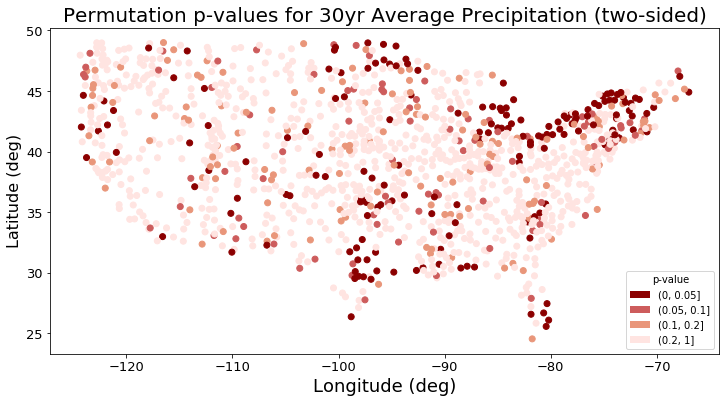

In [57]:
### Create map plot ###

fig, ax = plt.subplots(figsize=(12,6))

# create legend
legend_labels = ["(0, 0.05]", "(0.05, 0.1]", "(0.1, 0.2]", "(0.2, 1]"]
legend_boxes = []
for col_i in range(7, 0, -2):
    box = Rectangle((0, 0), 1, 1, fc=color_palette[col_i])
    legend_boxes.append(box)

ax.scatter(x_vals_perm, y_vals_perm, color=colors_perm)
ax.set_title('Permutation p-values for 30yr Average Precipitation (two-sided)', fontsize=20)
ax.set_xlabel('Longitude (deg)', fontsize=18)
ax.set_ylabel('Latitude (deg)', fontsize=16)
ax.legend(legend_boxes, legend_labels, title="p-value", loc="lower right")
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("map-plot-perm-pvalues-2sided.jpeg")

plt.show()

### Discussion

From this map plot, it appears that there is a statistically significant difference in average summer rainfall from the 1905-1935 time period to the 1985-2015 time period.

The most significant changes in this average summer rainfall occur across the north-easterly states and a few states in the middle of the US.

<a id="diff-investigation"></a>
### Investigation into nature of precipitation difference between the time periods

So we know that there is a statistically significant difference in average summer rainfall between these two time periods across some states, but we do not yet know whether this is an *increase* or *decrease* in average summer rainfall.

The following analyses investigate this.

#### Histogram showing spread of average summer precipitation differences from the 1905-1935 to the 1985-2015 time period

In [144]:
### Look at spread of average summer precipitation differences from 1905-1935 time period to 1985-2015 time period ###

prcp_diff_df = pd.DataFrame(columns=["id", "prcp_diff"])
prcp_diff_df = prcp_diff_df.set_index("id")

for station_i in range(len(perm_test_stats.index)):
    
    station = perm_test_stats.index[station_i]
    
    test_stat = perm_test_stats.iloc[station_i, 0]
    
    if not np.isnan(test_stat):
        prcp_diff_df.loc[station, :] = [test_stat]

In [145]:
prcp_diff_df.to_csv("prcp_diff.csv")
prcp_diff_df.head()

,prcp_diff
id,
USH00031596,-11.632778
USH00244522,0.557743
USH00410639,6.283611
USH00103732,2.199187
USH00051564,5.191944


In [146]:
prcp_diff_df = pd.read_csv("prcp_diff.csv", index_col='id')

In [147]:
print("min change:", np.min(prcp_diff_df.prcp_diff))
print("max change:", np.max(prcp_diff_df.prcp_diff))

min change: -36.41088516746407
max change: 41.37465277777778


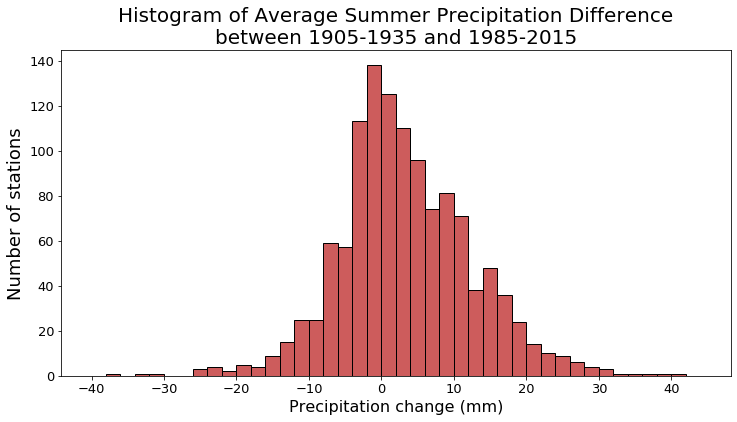

In [148]:
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(prcp_diff_df.prcp_diff.astype(float), bins=np.arange(-40, 45, 2), color=color_palette[5], edgecolor="black")
ax.set_title('Histogram of Average Summer Precipitation Difference\nbetween 1905-1935 and 1985-2015', fontsize=20)
ax.set_ylabel('Number of stations', fontsize=18)
ax.set_xlabel('Precipitation change (mm)', fontsize=16)
ax.set_xticks(np.arange(-40, 45, 10))
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("histogram-prcp-diff-timeperiods.jpeg")

plt.show()

### Discussion

This distribution is also relatively normally distributed but has a slight left-skew. This indicates that a greater number of weather stations reported a higher average summer rainfall over the 1985-2015 time period than they reported for the 1905-1935 time period.

The majority of weather stations experienced a change in +-10mm of average summer rainfall between these two periods.

So it does appear that more summer rainfall is being experienced when we compare the averages across these two time periods.

#### Upper and lower permutation test

Now we will perform a permutation test to determine:
1. The fraction of permuted test cases for which our observed test statistic is *greater*
2. The fraction of permuted test cases for which our observed test statistic is *smaller*

In [97]:
### Compute the fraction of permuted cases for which our observed test statistic is greater ###

p_value2_df = pd.DataFrame(columns=["id", "frac_greater", "p-value"])
p_value2_df = p_value2_df.set_index("id")

for station_i in range(len(perm_test_stats.index)):
    
    station = perm_test_stats.index[station_i]
    
    times_greater_than = 0 #counter for the number of times test statistic is greater than permuted case
    
    test_stat = perm_test_stats.iloc[station_i, 0]
    h0_mean = np.mean(perm_test_stats.iloc[station_i, 1:])
    for i in range(1,501):
        perm_test_stat = perm_test_stats.iloc[station_i, i]
        if (perm_test_stat - h0_mean) < (test_stat - h0_mean):
            times_greater_than += 1
            
    frac_greater = times_greater_than/500.0
            
    p_value2_df.loc[station, :] = [frac_greater, 1-frac_greater]

In [98]:
### Classify the p-values ###

classes = []
for station in p_value2_df.index:
    classes.append(classify_p(p_value2_df.loc[station, "p-value"]))
p_value2_df["classes"] = classes
p_value2_df.to_csv("p_values2.csv")
p_value2_df.head()

,frac_greater,p-value,classes
id,,,
USH00031596,0.044,0.956,1
USH00244522,0.546,0.454,1
USH00410639,0.722,0.278,1
USH00103732,0.732,0.268,1
USH00051564,0.816,0.184,3


In [99]:
### Get values for plot ###

x_vals_perm = [station_meta.loc[s_id, "longitude"] for s_id in p_value2_df.index]
y_vals_perm = [station_meta.loc[s_id, "latitude"] for s_id in p_value2_df.index]
colors_perm = [color_palette[s_class] for s_class in p_value2_df.classes]

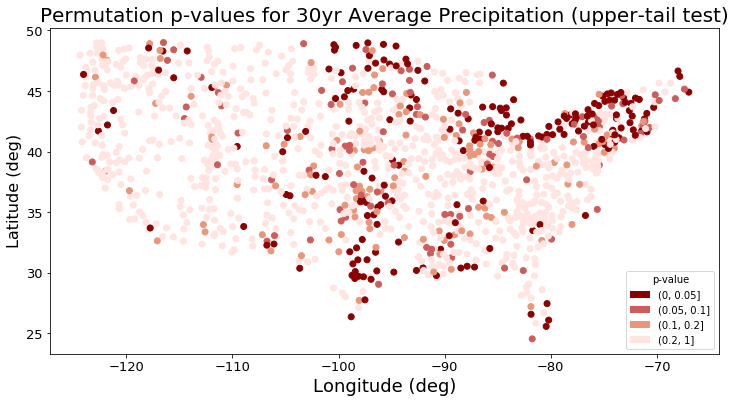

In [100]:
### Create map plot ###

fig, ax = plt.subplots(figsize=(12,6))

# create legend
legend_labels = ["(0, 0.05]", "(0.05, 0.1]", "(0.1, 0.2]", "(0.2, 1]"]
legend_boxes = []
for col_i in range(7, 0, -2):
    box = Rectangle((0, 0), 1, 1, fc=color_palette[col_i])
    legend_boxes.append(box)

ax.scatter(x_vals_perm, y_vals_perm, color=colors_perm)
ax.set_title('Permutation p-values for 30yr Average Precipitation (upper-tail test)', fontsize=20)
ax.set_xlabel('Longitude (deg)', fontsize=18)
ax.set_ylabel('Latitude (deg)', fontsize=16)
ax.legend(legend_boxes, legend_labels, title="p-value", loc="lower right")
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("map-plot-perm-pvalues-upper.jpeg")

plt.show()

In [101]:
### Compute the fraction of permuted cases for which our observed test statistic is smaller ###

p_value3_df = pd.DataFrame(columns=["id", "frac_smaller", "p-value"])
p_value3_df = p_value3_df.set_index("id")

for station_i in range(len(perm_test_stats.index)):
    
    station = perm_test_stats.index[station_i]
    
    times_smaller_than = 0 #counter for the number of times test statistic is smaller than permuted case
    
    test_stat = perm_test_stats.iloc[station_i, 0]
    h0_mean = np.mean(perm_test_stats.iloc[station_i, 1:])
    for i in range(1,501):
        perm_test_stat = perm_test_stats.iloc[station_i, i]
        if (perm_test_stat - h0_mean) > (test_stat - h0_mean):
            times_smaller_than += 1
            
    frac_smaller = times_smaller_than/500.0
            
    p_value3_df.loc[station, :] = [frac_smaller, 1-frac_smaller]

In [103]:
### Classify the p-values ###

classes = []
for station in p_value3_df.index:
    classes.append(classify_p(p_value3_df.loc[station, "p-value"]))
p_value3_df["classes"] = classes
p_value3_df.to_csv("p_values3.csv")
p_value3_df.head()

,frac_smaller,p-value,classes
id,,,
USH00031596,0.956,0.044,7
USH00244522,0.454,0.546,1
USH00410639,0.278,0.722,1
USH00103732,0.268,0.732,1
USH00051564,0.184,0.816,1


In [104]:
### Get values for plot ###

x_vals_perm = [station_meta.loc[s_id, "longitude"] for s_id in p_value3_df.index]
y_vals_perm = [station_meta.loc[s_id, "latitude"] for s_id in p_value3_df.index]
colors_perm = [color_palette[s_class] for s_class in p_value3_df.classes]

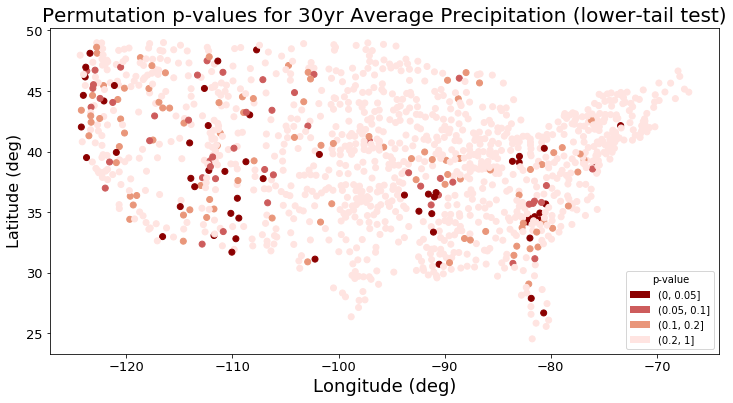

In [106]:
### Create map plot ###

fig, ax = plt.subplots(figsize=(12,6))

# create legend
legend_labels = ["(0, 0.05]", "(0.05, 0.1]", "(0.1, 0.2]", "(0.2, 1]"]
legend_boxes = []
for col_i in range(7, 0, -2):
    box = Rectangle((0, 0), 1, 1, fc=color_palette[col_i])
    legend_boxes.append(box)

ax.scatter(x_vals_perm, y_vals_perm, color=colors_perm)
ax.set_title('Permutation p-values for 30yr Average Precipitation (lower-tail test)', fontsize=20)
ax.set_xlabel('Longitude (deg)', fontsize=18)
ax.set_ylabel('Latitude (deg)', fontsize=16)
ax.legend(legend_boxes, legend_labels, title="p-value", loc="lower right")
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("map-plot-perm-pvalues-lower.jpeg")

plt.show()

### Discussion

At a greater number of weather stations, the average summer rainfall for the 1985-2015 time period was statistically significantly greater than the average summer rainfall for the 1905-1935 time period.

There are fewer weather stations that reported a statistically significantly lower average summer rainfall for the 1985-2015 time period than for the 1905-1935 time period.

Overall, this supports our hypothesis that the precipitation is becoming more severe.

#### Compute the fraction of times the summer precipitation value for a year in the 1985-2015 time period was greater than or less than/equal to the average summer precipitation value for the 1905-1935 time period

In [111]:
### Compute the fraction of times the summer precipitation value for a year in the later time period
# was greater or less/equal to the average summer precipitation value for the earlier time period ###

time_p_diff_df = pd.DataFrame(columns=["id", "frac_greater_than", "frac_smaller_than"])
time_p_diff_df = time_p_diff_df.set_index("id")

for station in perm_test_stats.index:
    
    num_valid_values = 0
    times_greater_than = 0
    times_smaller_than = 0
    
    first_p_avg = np.mean(prcp_perm_master1.loc[station, :])
    
    second_p_values = list(prcp_perm_master2.loc[station, :])
    
    for val in second_p_values:
        if not np.isnan(val):
            num_valid_values += 1
            if val > first_p_avg:
                times_greater_than += 1
            else:
                times_smaller_than += 1
                
    num_valid_values = float(num_valid_values)
            
    time_p_diff_df.loc[station, :] = [times_greater_than/num_valid_values, times_smaller_than/num_valid_values]

In [112]:
print(time_p_diff_df.shape)
time_p_diff_df.to_csv("time_p_diff.csv")
time_p_diff_df.head()

(1218, 2)


,frac_greater_than,frac_smaller_than
id,,
USH00031596,0.333333,0.666667
USH00244522,0.344828,0.655172
USH00410639,0.5,0.5
USH00103732,0.533333,0.466667
USH00051564,0.6,0.4


In [121]:
### Classify the fractions ###
# each fraction is put into an interval only if it is greater than 0.5
# so for each station we will have a classification that:
    #1. first specifies if a greater proportion of summer
    #precipitation values in second time period were greater than average for first time period
    #2. specifies how high above 0.5 this proportion was

classes = []
stations_greater = 0
stations_smaller = 0
    
for station in time_p_diff_df.index:
    
    greater = time_p_diff_df.loc[station, "frac_greater_than"]
    smaller = time_p_diff_df.loc[station, "frac_smaller_than"]
    
    if greater > smaller:
        classes.append(classify_frac(greater, "upper"))
        stations_greater += 1
    else:
        classes.append(classify_frac(smaller, "lower"))
        stations_smaller += 1

time_p_diff_df["classes"] = classes
time_p_diff_df.to_csv("time_p_diff.csv")
time_p_diff_df.head()

,frac_greater_than,frac_smaller_than,classes
id,,,
USH00031596,0.333333,0.666667,-2
USH00244522,0.344828,0.655172,-2
USH00410639,0.5,0.5,-1
USH00103732,0.533333,0.466667,1
USH00051564,0.6,0.4,2


In [143]:
time_p_diff_df = pd.read_csv("time_p_diff.csv", index_col='id')

In [122]:
print("stations_greater:", stations_greater)
print("stations_smaller:", stations_smaller)

stations_greater: 551
stations_smaller: 667


In [144]:
### Get values for plot ###

x_vals_perm = [station_meta.loc[s_id, "longitude"] for s_id in time_p_diff_df.index]
y_vals_perm = [station_meta.loc[s_id, "latitude"] for s_id in time_p_diff_df.index]
colors_perm = [color_palette2[s_class] for s_class in time_p_diff_df.classes]

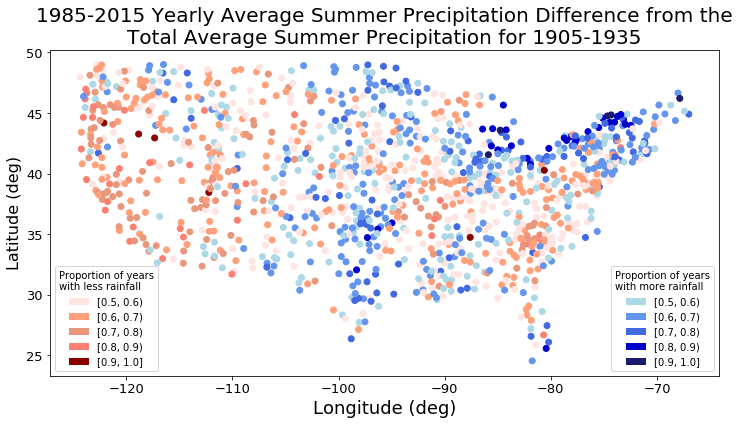

In [149]:
### Create map plot ###

fig, ax = plt.subplots(figsize=(12,6))

# create legend
legend1_labels = ["(0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)", "[0.8, 0.9)", "[0.9, 1.0]"]
legend1_boxes = []
for col_i in range(1, 6, 1):
    box = Rectangle((0, 0), 1, 1, fc=color_palette2[col_i])
    legend1_boxes.append(box)

legend2_labels = ["[0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)", "[0.8, 0.9)", "[0.9, 1.0]"]
legend2_boxes = []
for col_i in range(-1, -6, -1):
    box = Rectangle((0, 0), 1, 1, fc=color_palette2[col_i])
    legend2_boxes.append(box)

ax.scatter(x_vals_perm, y_vals_perm, color=colors_perm)
ax.set_title('1985-2015 Yearly Average Summer Precipitation Difference from the\nTotal Average Summer Precipitation for 1905-1935', fontsize=20)
ax.set_xlabel('Longitude (deg)', fontsize=18)
ax.set_ylabel('Latitude (deg)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=13)

lg1 = ax.legend(legend1_boxes, legend2_labels, title="Proportion of years\nwith more rainfall", loc="lower right")
lg2 = ax.legend(legend2_boxes, legend2_labels, title="Proportion of years\nwith less rainfall", loc="lower left")
ax.add_artist(lg1)

plt.savefig("map-plot-time_p_diff.jpeg")

plt.show()

### Discussion

Basic description according to the keys: weather stations by dots on the red color spectrum are stations that, when compared to the total average summer precipitation over 1905-1935, reported a *lower* summer average rainfall for more than 50% of years; weather stations by dots on the red color spectrum are stations that, when compared to the total average summer precipitation over 1905-1935, reported a *higher* summer average rainfall for more than 50% of years.

Number of stations at which more than 50% of years between 1985 and 2015 had a *higher* average summer precipitation than the total average summer precipitation for the 1905-1935 period: 551

Number of stations at which more than 50% of years between 1985 and 2015 had a *lower* average summer precipitation than the total average summer precipitation for the 1905-1935 period: 667

From this map plot and the above statistics, it seems that while there are slightly more weather stations at which more than 50% of years between 1985 and 2015 had a *higher* average summer precipitation than the total average summer precipitation for the 1905-1935 period, there are only approximately 100 (out of 1218) more stations at which this is the case. Therefore, there is still strong evidence that a significant number of weather stations reported more summer rainfall in a high proportion of years in the more recent time period than in the earlier one.

Additionally, looking at the distribution of colors in this map plot, we see that there are more points that there are more darker blue points than darker red points. This indicates that when a weather station reported more summer rainfall in a high proportion of years in the more recent time period than in the earlier one, this proportion of years with higher rainfall was typically greater than the proportion of years reported to have less rainfall by another weather station. In other words, if one weather station A had x proportion of years in the later time period with more rainfall than the first time period's average, and another weather station B had y proportion of years in the later time period with less rainfall than the first time period's average, x is likely to be higher than y.

Overall, this further adds evidence supporting the claim that rainfall is increasing in severity, because when there is more rainfall there is *a lot more* rainfall, while when there is less rainfall, the difference is not as extreme.

<a id="regions"></a>
## 4. Comparison of Average Rainfall Trends between US Regions

I am interested in any observable average rainfall trends between the Western, Midwestern, Northeastern and Southern regions in the US.

To carry out this analysis, each weather station was placed into a region category based on the state in which it fell and based on the region segmentation of the US according to this [map](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Census_Regions_and_Division_of_the_United_States.svg/1920px-Census_Regions_and_Division_of_the_United_States.svg.png).

For all weather stations in each region, the average annual precipitation was computed across 5 year intervals starting in 1900, with the last interval starting in 2010.

In [13]:
station_meta.head()

,component_1,component_2,component_3,coop_id,country_code,elevation,id_place_holder,latitude,longitude,name,network_code,state,utc_offset
id,,,,,,,,,,,,,
USH00011084,------,------,------,11084,US,25.9,0,31.0581,-87.0547,BREWTON 3 SSE,H,AL,6
USH00012813,------,------,------,12813,US,7.0,0,30.5467,-87.8808,FAIRHOPE 2 NE,H,AL,6
USH00013160,011694,------,------,13160,US,38.1,0,32.8347,-88.1342,GAINESVILLE LOCK,H,AL,6
USH00013511,------,------,------,13511,US,67.1,0,32.7017,-87.5808,GREENSBORO,H,AL,6
USH00013816,------,------,------,13816,US,132.0,0,31.8700,-86.2542,HIGHLAND HOME,H,AL,6


In [19]:
"DC" in list(station_meta.state)

False

In [24]:
regions = ["west", "midwest", "northeast", "south"]

In [20]:
west_states = ["AK", "WA", "OR", "CA", "ID", "MT", "WY", "NV", "UT", "CO", "AZ", "NM", "HI"]
midwest_states = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
northeast_states = ["NY", "PA", "NJ", "VT", "NH", "MA", "CT", "RI", "ME"]
south_states = ["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", "GA", "FL", "SC", "NC", "WV", "VA", "MD", "DE"]
print(len(west_states) + len(midwest_states) + len(northeast_states) + len(south_states))

50


In [21]:
west_stations, midwest_stations, northeast_stations, south_stations = [], [], [], []

In [22]:
for station in station_meta.index:
    
    if station_meta.loc[station, "state"] in west_states:
        west_stations.append(station)
    elif station_meta.loc[station, "state"] in midwest_states:
        midwest_stations.append(station)
    elif station_meta.loc[station, "state"] in northeast_states:
        northeast_stations.append(station)
    elif station_meta.loc[station, "state"] in south_states:
        south_stations.append(station)
    else:
        print("missing:", station, station_meta.loc[station, "state"])

In [23]:
print(len(west_stations) + len(midwest_stations) + len(northeast_stations) + len(south_stations))

1218


In [82]:
### Take average rainfall in each region over 5 year periods from 1900 to 2015 ###

west_df = pd.DataFrame(columns=list(range(1900,2011,5)), index=["id"])
midwest_df = pd.DataFrame(columns=list(range(1900,2011,5)), index=["id"])
northeast_df = pd.DataFrame(columns=list(range(1900,2011,5)), index=["id"])
south_df = pd.DataFrame(columns=list(range(1900,2011,5)), index=["id"])

year_intervals = range(1900,2011,5)
month_vals = ["value"+str(i) for i in range(0, 12)]

for prcp_file in prcp_files:

    station_id = prcp_file.split(".")[0]
    station_avgs = []
    
    prcp_df = pd.read_csv("csvs/"+prcp_file)

    # make sure year values are ints and dataframe is sorted by year
    assert(prcp_df.year.dtype is np.dtype('int64'))
    prcp_df = prcp_df.sort_values(by="year")
    # set index=year for easy access
    prcp_df = prcp_df.set_index("year")
    
    for year in year_intervals[::1]:
        #print(year)
        time_p_avg_vals = []
        for year_i in range(year,year+5):
            
            prcps = 0
            month_count = 0
            for month in month_vals:
                try:
                    prcp_val = prcp_df.loc[year, month]
                    if prcp_val > 0:
                        prcps += (prcp_val/10.0) #convert to mm
                        month_count += 1
                except KeyError:
                    continue

            if month_count != 0:
                prcp_avg = prcps/float(month_count)
            else:
                prcp_avg = np.nan
            
            time_p_avg_vals.append(prcp_avg)

        #print(time_p_avg_vals)
        
        station_avgs.append(np.mean(time_p_avg_vals))
    
    if station_id in west_stations:
        #print("west")
        west_df.loc[station_id, :] = station_avgs
        
    elif station_id in midwest_stations:
        #print("midwest")
        midwest_df.loc[station_id, :] = station_avgs
        
    elif station_id in northeast_stations:
        #print("northeast")
        northeast_df.loc[station_id, :] = station_avgs
        
    elif station_id in south_stations:
        #print("south")
        south_df.loc[station_id, :] = station_avgs
        
    else:
        print("missing:", station_id)
        


In [108]:
#west_df.to_csv("west_prcp.csv")
#south_df.to_csv("south_prcp.csv")
#northeast_df.to_csv("northeast_prcp.csv")
#midwest_df.to_csv("midwest_prcp.csv")

In [85]:
all_west_avgs = [np.mean(west_df[y]) for y in west_df.columns]
all_south_avgs = [np.mean(south_df[y]) for y in south_df.columns]
all_northeast_avgs = [np.mean(northeast_df[y]) for y in northeast_df.columns]
all_midwest_avgs = [np.mean(midwest_df[y]) for y in midwest_df.columns]

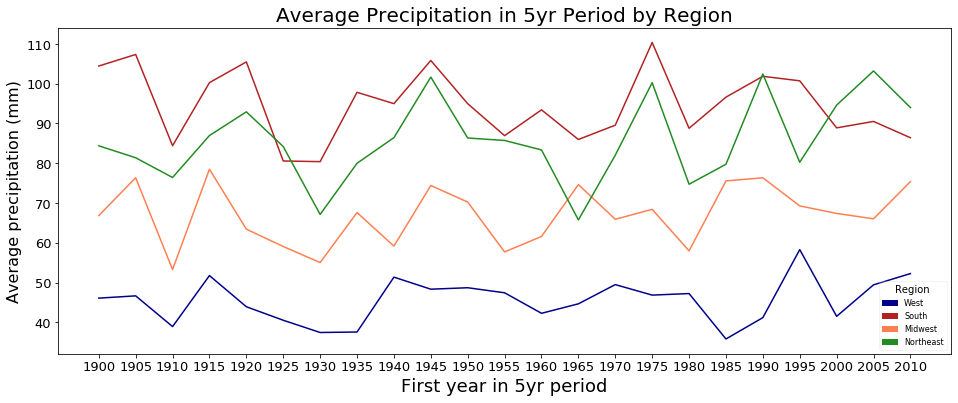

In [112]:
### Create line plot ###

fig, ax = plt.subplots(figsize=(16,6))

x_vals = range(1900, 2011, 5)

# create legend
legend_labels = ["West", "South", "Midwest", "Northeast"]
legend_boxes = []
for col in ["#00008b", "#b22222", "#ff7f50", "#228b22"]:
    box = Rectangle((0, 0), 1, 1, fc=col)
    legend_boxes.append(box)

ax.plot(x_vals, all_west_avgs, color="#00008b")
ax.plot(x_vals, all_south_avgs, color="#b22222")
ax.plot(x_vals, all_midwest_avgs, color="#ff7f50")
ax.plot(x_vals, all_northeast_avgs, color="#228b22")
ax.set_title('Average Precipitation in 5yr Period by Region', fontsize=20)
ax.set_xlabel('First year in 5yr period', fontsize=18)
ax.set_ylabel('Average precipitation (mm)', fontsize=16)
ax.legend(legend_boxes, legend_labels, title="Region", loc="lower right", framealpha=0.2, fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xticks(list(x_vals))

plt.savefig("line-plot-region-yearly-avg.jpeg")

plt.show()

### Discussion

It appears that each US region (west, northeast, midwest or south) has a very distinct range of average precipitation values. Yearly average precipitation in the South is consistently higher than in the Northeast, the yearly precipitation in the Northeast is consistently higher than in the Midwest, and the yearly average precipitation is consistently the lowest in the West.

This is interesting when compared with our Permutation p-Value plot, because the most significant changes in rainfall were not observed in the South. So it appears that while rainfall in the South is high, it is consistently high rather than having recently increased.

Also, the very regular peaks and troughs in each line in the plot above are somewhat relieving in light of the continued warnings about the immediate and severe effects of climate change. This is not to say that periods of more severe rainfall are not to come, but we can at least be assuaged by the fact that discrete periods of severe rainfall are common the history of the US.